## Run SPQRQL query to fetch data from GraphDB and Benchmark performance

In [1]:
from SPARQLWrapper import SPARQLWrapper, BASIC, GET, JSON, POST
import time
import json

In [2]:
CONECTION_STRING={
    "hostname":"http://localhost:7200",
    "repository":"test_insert",
    "username":"admin",
    "password":"admin"
}


In [9]:
def _connect_gdb(connection_details, request_type="get"): 
    """
    Connects to a graph database using the provided connection details.

    Parameters:
    - connection_details (dict): A dictionary containing connection details.
      Expected keys: 'username', 'password', 'hostname', 'repository'.
    - request_type (str): The type of request ('get' or 'post').

    Returns:
    - SPARQLWrapper: An instance of SPARQLWrapper configured for the specified request type.
    """
    username = connection_details.get("username")
    password = connection_details.get("password")
    hostname = connection_details.get("hostname")
    repository = connection_details.get("repository")

    if not (username and password and hostname and repository):
        raise ValueError("Connection parameters missing.")

    if request_type == "get":
        endpoint = f"{hostname}/repositories/{repository}"
    elif request_type == "post":
        endpoint = f"{hostname}/repositories/{repository}/statements"
    else:
        raise ValueError("Invalid request type. Use 'get' or 'post'.")

    try:
        sparql = SPARQLWrapper(endpoint)
        sparql.setHTTPAuth(BASIC)
        sparql.setCredentials(username, password)
        return sparql
    except Exception as e:
        raise ConnectionError(f"Failed to connect to the graph database: {str(e)}")

In [4]:
def execute_query(connection_details, sparql_query): 
    
    sparql = _connect_gdb(connection_details)
    if sparql:
        try:
            # Set SPARQL query parameters
            sparql.setMethod(GET)
            sparql.setQuery(sparql_query)
            sparql.setReturnFormat(JSON)

            # Execute the query and measure execution time
            start_time = time.time()
            result = sparql.query().convert()
            end_time = time.time()
            execution_time = end_time - start_time

            # Return results and execution time
            return json.dumps({"execution_time": execution_time, "result": result}, indent=3)
        except Exception as e:
            # query execution errors
            return f"Error: {str(e)}"
    else:
        # connection failure
        return "Error: Failed to connect to the graph database."

In [24]:
def plot(data, title, label_txt, Xlablel, filename):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(rc={'figure.figsize':(20,11)})  
    x = range(1,len(data)+1) 
    y = data
 
    plt.plot(x, data, marker='x', linestyle='--', label=label_txt, color='b') 

    # Adding labels and title
    plt.xlabel(Xlablel, fontsize=30)
    plt.ylabel('Execution time (Seconds)', fontsize=30)
    plt.title(title, fontsize=30)
    plt.xticks(fontsize=15) 
    plt.yticks(fontsize=15)  
    plt.savefig(f"{filename}.png")

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

### Start test on different queries

In [25]:
def start_test(query, iterations):
    """This test is intended to observer the query response time for the same query"""

    response_time_with_data = []
    for i in range(0, iterations+1):
        query_resp = json.loads(execute_query(CONECTION_STRING, sparql_query))
        if query_resp["result"]["results"]["bindings"]:  
            response_time_with_data.append(query_resp["execution_time"])
    
    return response_time_with_data
    

## Get all assets list

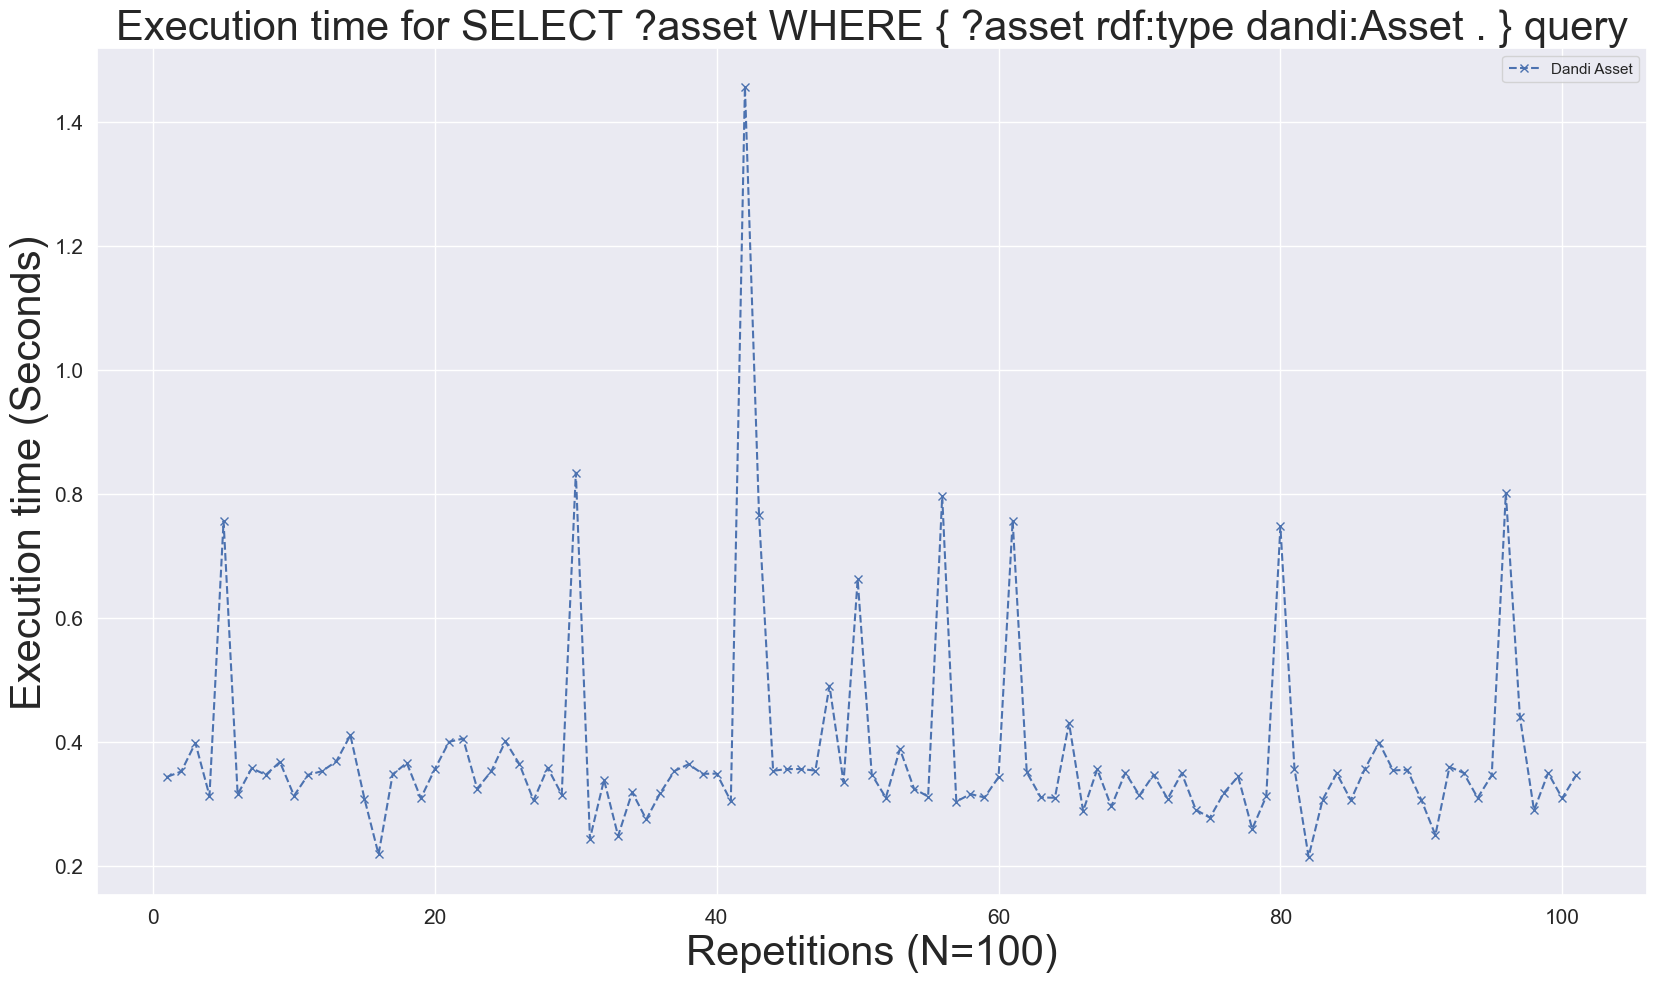

In [44]:
sparql_query = """
PREFIX dandi: <http://schema.dandiarchive.org/>
PREFIX schema: <https://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX prov: <http://www.w3.org/ns/prov#> 
SELECT ?asset 
WHERE {
    ?asset rdf:type dandi:Asset .
}
"""
plot(
    start_test(sparql_query, 100),
    "Execution time for SELECT ?asset WHERE { ?asset rdf:type dandi:Asset . } query",
    "Dandi Asset",
    "Repetitions (N=100)",
    "asset_only_query")
    

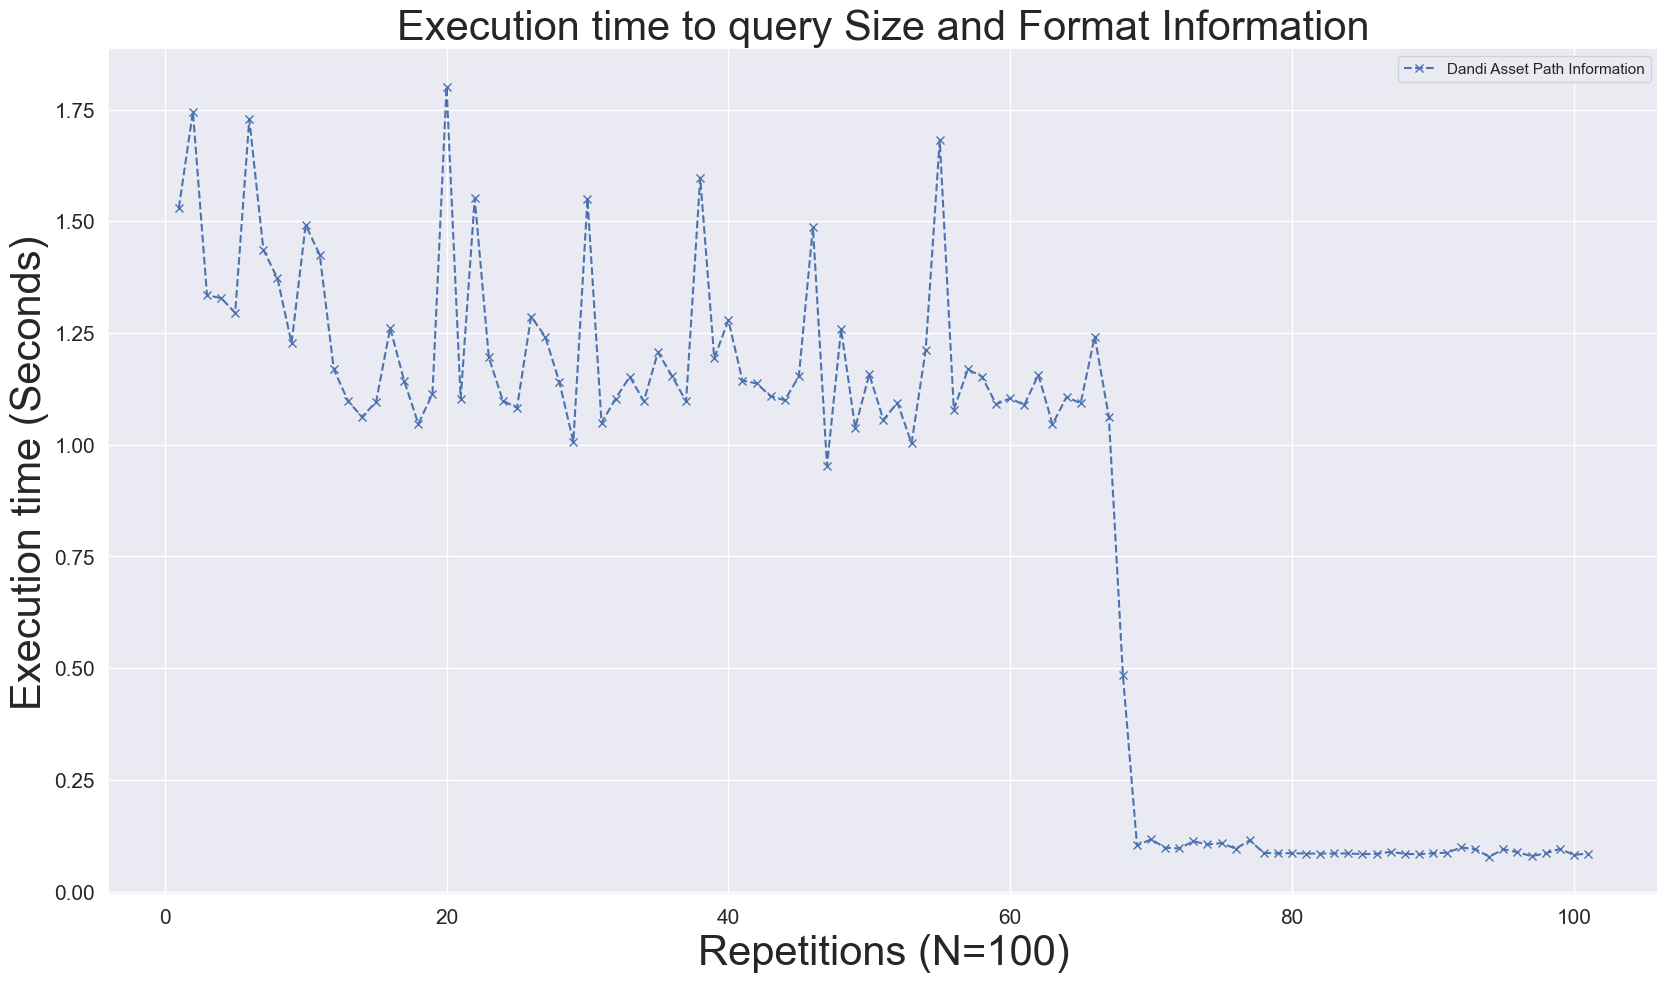

In [45]:
sparql_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dandi: <http://schema.dandiarchive.org/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX schema: <http://schema.org/>
SELECT ?asset ?path ?d ?size ?format
WHERE {
    ?asset rdf:type dandi:Asset .
    ?d prov:hasMember ?asset .
    ?asset dandi:path ?path ;
       schema:contentSize ?size ;
       schema:encodingFormat ?format .
}
"""
plot(
    start_test(sparql_query, 100),
    "Execution time to query Size and Format Information",
    "Dandi Asset Path Information",
    "Repetitions (N=100)",
    "asset_asset_path_query")

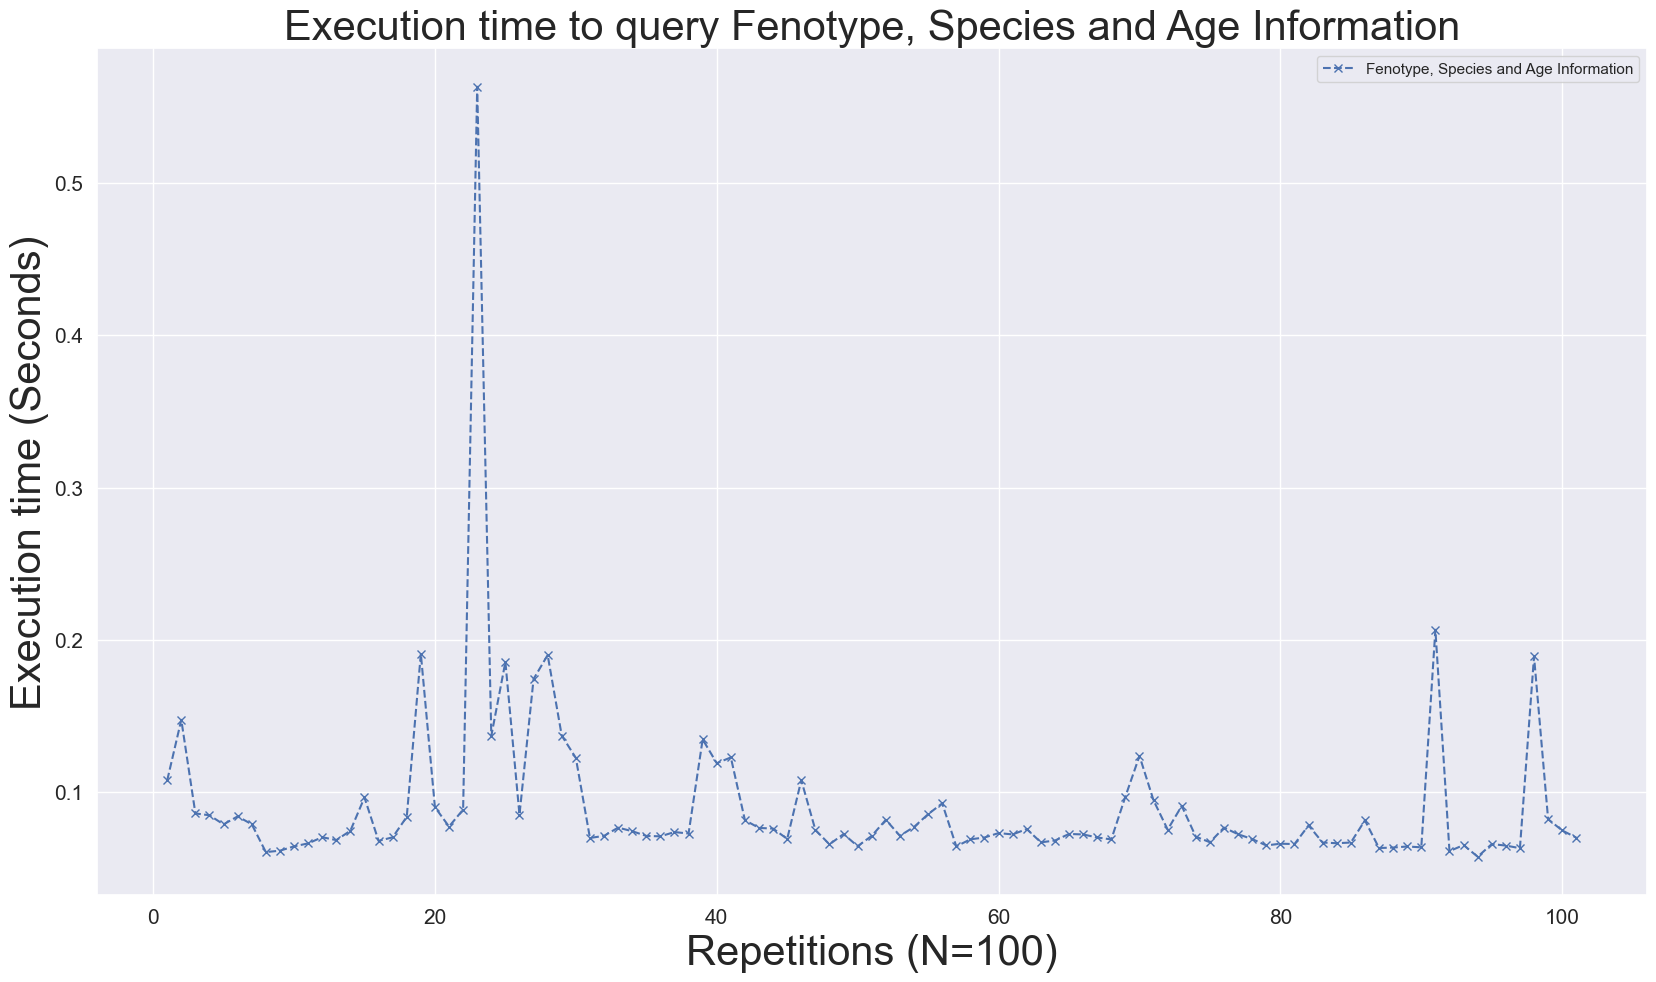

In [46]:
sparql_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dandi: <http://schema.dandiarchive.org/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX schema: <http://schema.org/>
SELECT DISTINCT ?sub_id ?d ?gen ?spc ?age
WHERE {
    ?asset rdf:type dandi:Asset .
    ?d prov:hasMember ?asset .
    ?asset prov:wasAttributedTo ?sub .
    ?sub rdf:type dandi:Participant ;
          dandi:genotype ?gen ;
          schema:identifier ?sub_id ;
          dandi:species / schema:name ?spc ;
          dandi:age / schema:value ?age .
}
"""
plot(
    start_test(sparql_query, 100),
    "Execution time to query Fenotype, Species and Age Information",
    "Fenotype, Species and Age Information",
    "Repetitions (N=100)",
    "species_age_fenotype")